## Define Area of Interest (AOI)

Use the map below to draw a rectangle defining your processing area. The maximum size is approximately 600x600 pixels at 10m resolution.

In [2]:
import openeo
from extractor import load_input_cube
from inference import inference_WAC

CRS = "EPSG:3035"
RESOLUTION = 10  # important; the resolution is implicitely tied to the CRS; so we need to use UTM based CRS here

PATCH_SIZE = 64
OVERLAP_SIZE = 16

SPATIAL_EXTENT = {
    'west': 300000,
    'south': 9800000,
    'east': 305000,  
    'north': 9805000,  
    'crs': CRS  
}

N_CLASSES = 21

TEMPORAL_EXTENT = ['2023-06-01', '2023-08-01'] 
MAX_CLOUD_COVER = 85


JOB_OPTIONS = {'driver-memory': '2000m',
 'driver-memoryOverhead': '2000m',
 'executor-memory': '3000m',
 'executor-memoryOverhead': '3000m',
 'python-memory': '8000m',
 'max-executors': 20,
 "udf-dependency-archives": [
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/onnx_dependencies_1.16.3.zip#onnx_deps",
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/FusionUNet_OilpalmModel_20250718131837.zip#onnx_models"
        ]
 }


In [3]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

input_cube = load_input_cube(connection, SPATIAL_EXTENT, TEMPORAL_EXTENT, MAX_CLOUD_COVER, RESOLUTION, CRS)
#inference_cube = inference_WAC(input_cube, patch_size=PATCH_SIZE, overlap = OVERLAP_SIZE)
#ROI_inference_cube =ROI_inference_cube.rename_labels(dimension = 'bands', target = new_band_names)


input_cube = input_cube.save_result(format = "netCDF")


job = connection.create_job(input_cube,
    additional=JOB_OPTIONS
)

job.start_and_wait()



Authenticated using refresh token.
0:00:00 Job 'j-250722144027443694658297456a3fd2': send 'start'
0:00:13 Job 'j-250722144027443694658297456a3fd2': created (progress 0%)
0:00:18 Job 'j-250722144027443694658297456a3fd2': created (progress 0%)
0:00:25 Job 'j-250722144027443694658297456a3fd2': created (progress 0%)
0:00:33 Job 'j-250722144027443694658297456a3fd2': created (progress 0%)
0:00:43 Job 'j-250722144027443694658297456a3fd2': running (progress N/A)
0:00:55 Job 'j-250722144027443694658297456a3fd2': running (progress N/A)
0:01:11 Job 'j-250722144027443694658297456a3fd2': running (progress N/A)
0:01:32 Job 'j-250722144027443694658297456a3fd2': running (progress N/A)
0:03:36 Job 'j-250722144027443694658297456a3fd2': Connection error while polling job status: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
0:04:06 Job 'j-250722144027443694658297456a3fd2': Connection error while polling job status: HTTPSConnectionPool(host='openeo.dataspace.

<BatchJob job_id='j-250722144027443694658297456a3fd2'>

In [4]:
OUTPUT_DIR = "C:/Git_projects/WAC/production/prediction/input_test" + job.job_id
OUTPUT_FILE_ROI = f"{OUTPUT_DIR}"
job.get_results().download_files(OUTPUT_FILE_ROI)


[WindowsPath('C:/Git_projects/WAC/production/prediction/input_testj-250722144027443694658297456a3fd2/openEO.nc'),
 WindowsPath('C:/Git_projects/WAC/production/prediction/input_testj-250722144027443694658297456a3fd2/job-results.json')]

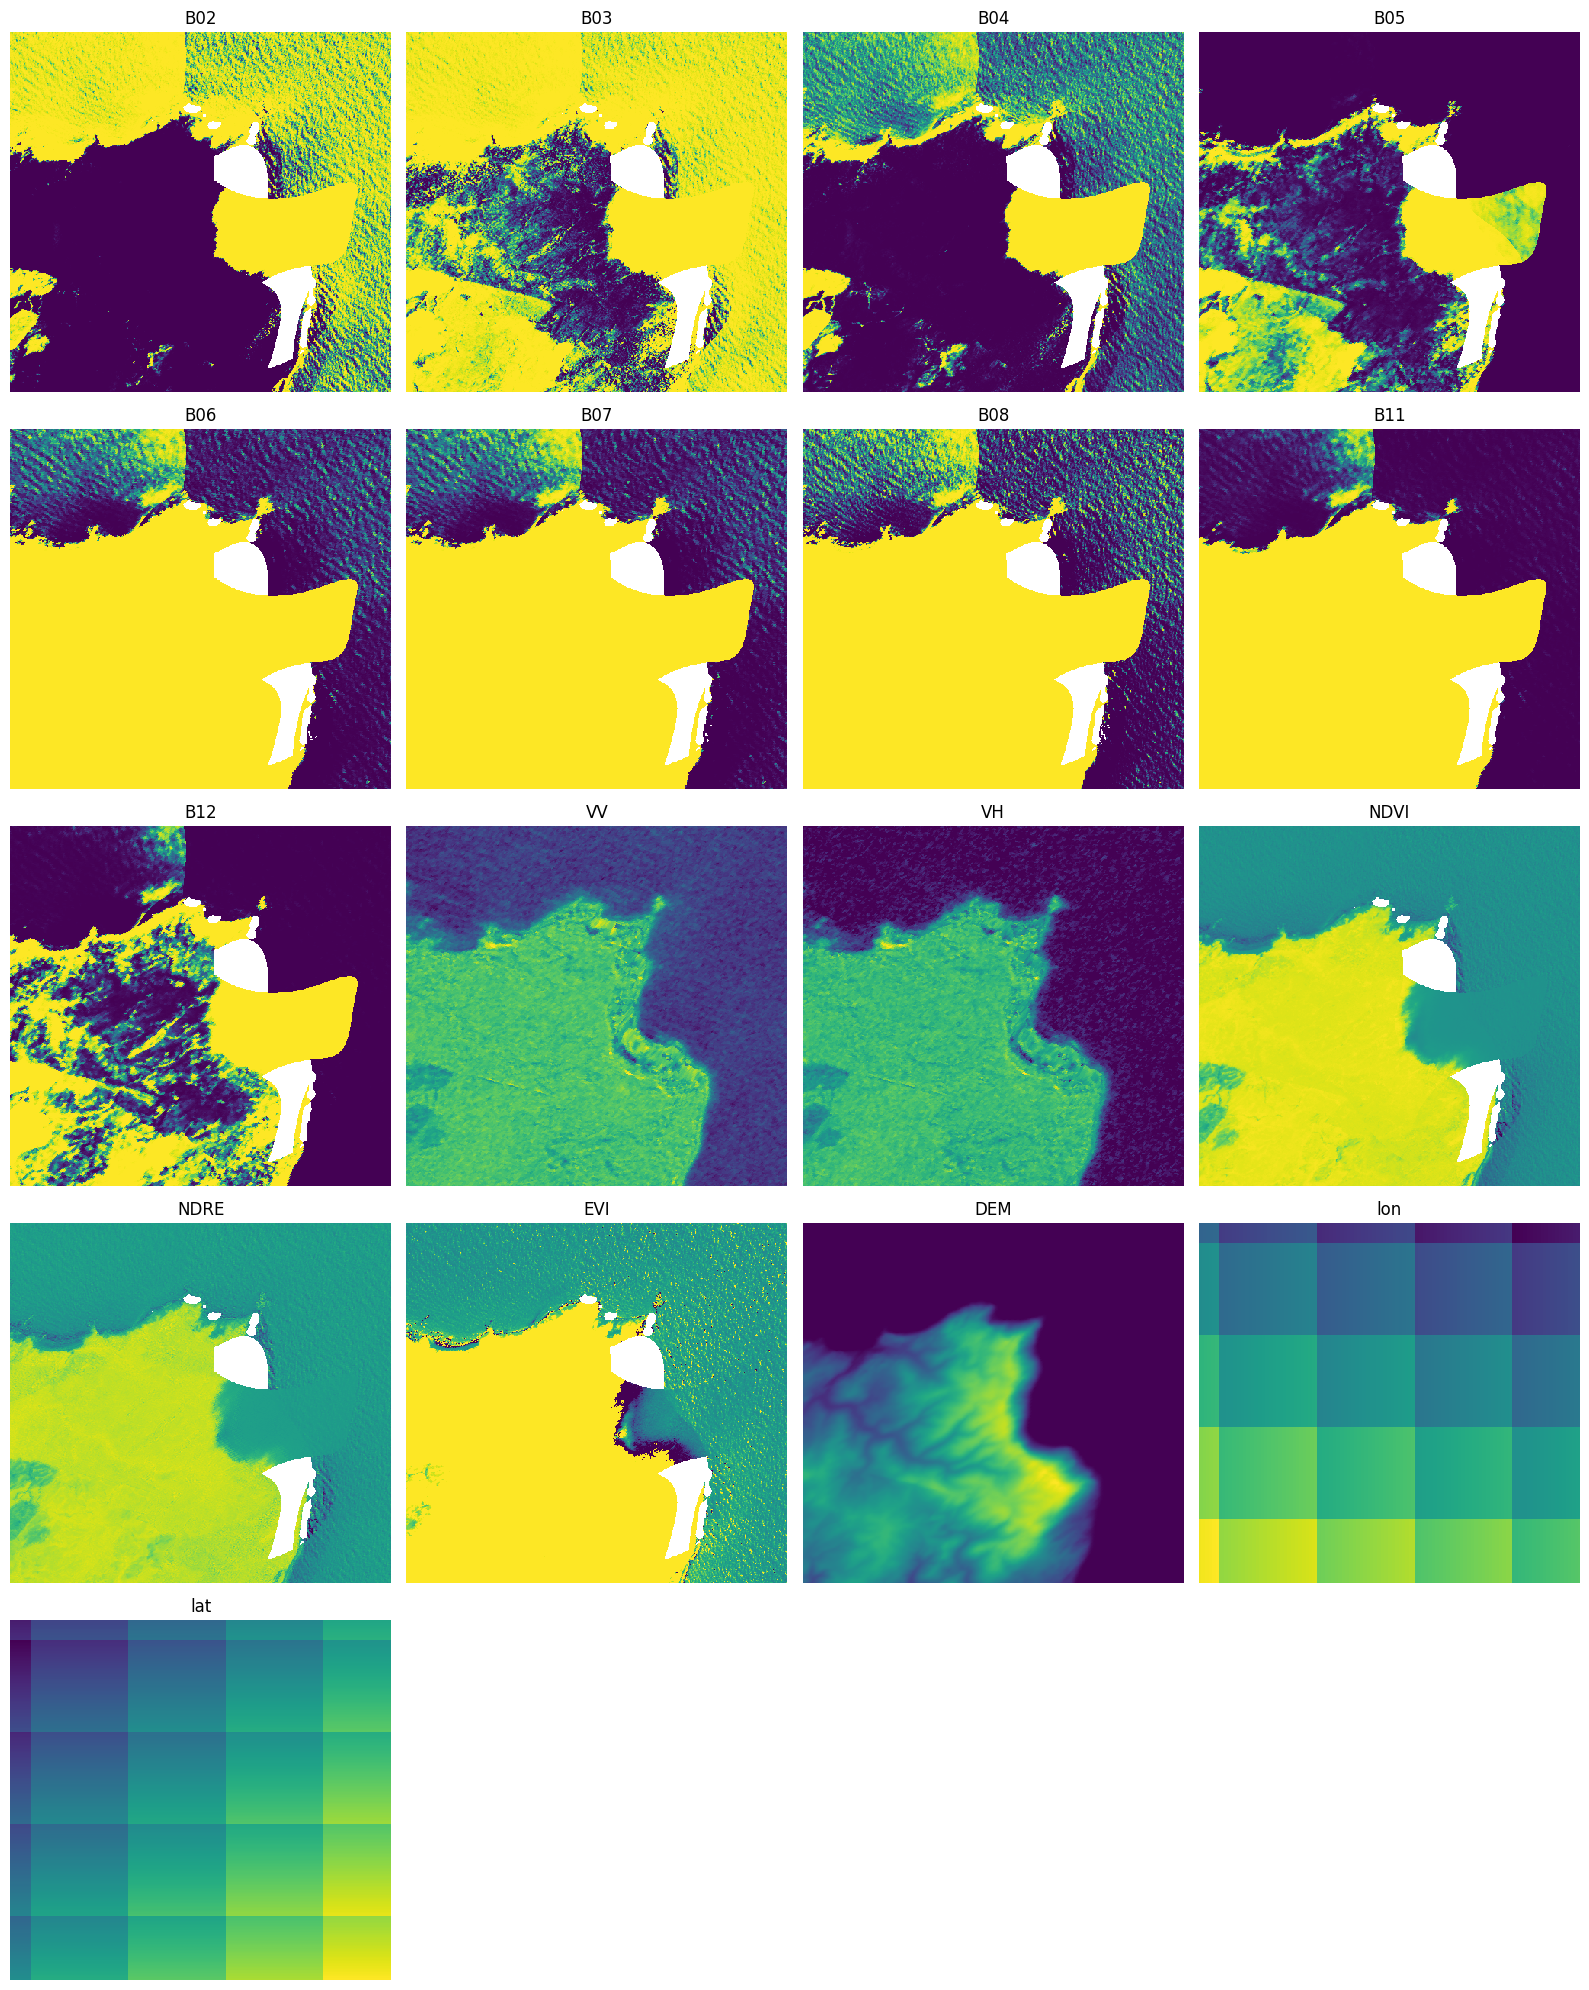

In [5]:


import matplotlib.pyplot as plt
import xarray as xr
# Load dataset
ds = xr.open_dataset("C:/Git_projects/WAC/production/prediction/input_testj-250722144027443694658297456a3fd2/openEO.nc")

# Filter only variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4  # adjust based on how wide you want the figure
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for i, var in enumerate(variables_to_plot):
    ax = axes.flat[i]
    ds[var].isel(t=0).plot(ax=ax, add_colorbar=False)
    ax.set_title(var)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes.flat)):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

